Replication Quality Metrics:
- Maximum absolute error: 0.0000
- Root mean squared error: 0.0000




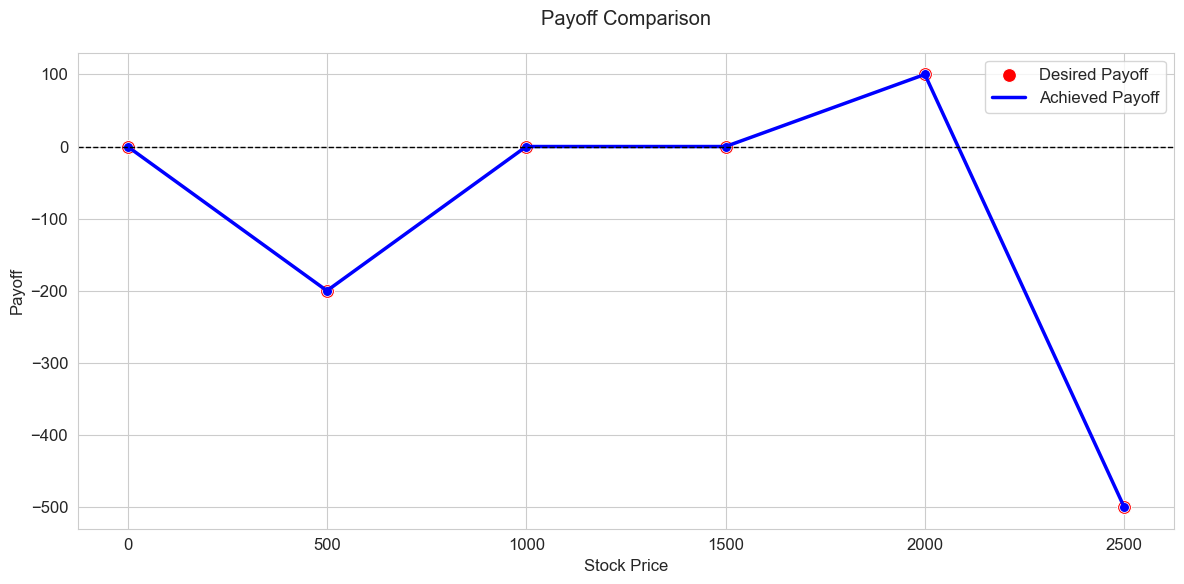

Portfolio Composition:


,Strike Price,Call Option Weight,Bond Position
0,0,-0.4,-0.0
1,500,0.8,-0.0
2,1000,-0.4,-0.0
3,1500,0.2,-0.0
4,2000,-1.4,-0.0
5,2500,0.0,-0.0


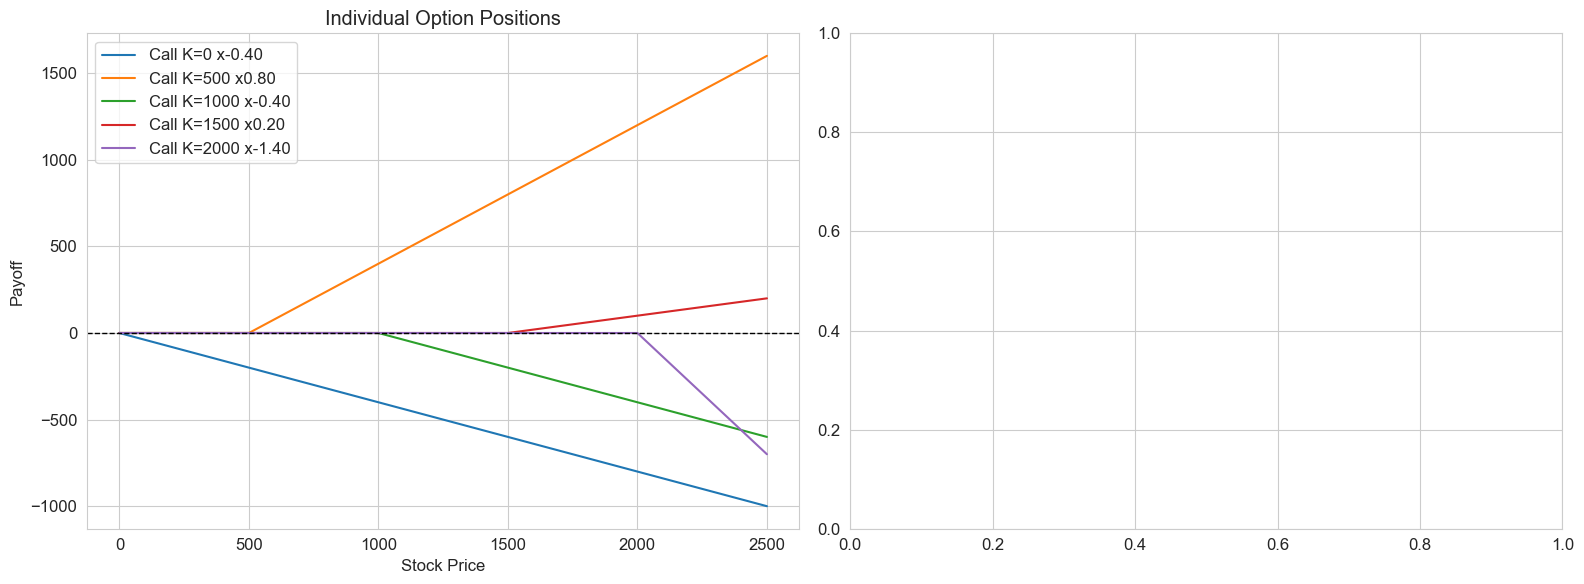

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
from typing import List, Tuple

# Set global style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

def option_payoff(stock_price: np.ndarray, strike_price: float) -> np.ndarray:
    """Calculate payoff for a call option at given stock prices.
    
    Args:
        stock_price: Array of stock prices
        strike_price: Strike price of the option
        
    Returns:
        Payoff array (max(S-K, 0))
    """
    return np.maximum(stock_price - strike_price, 0.)

def plot_payoff_comparison(stock_prices: np.ndarray, 
                          desired_payoffs: np.ndarray, 
                          achieved_payoffs: np.ndarray,
                          title: str = "Payoff Comparison") -> None:
    """Plot comparison between desired and achieved payoffs.
    
    Args:
        stock_prices: Array of stock price points
        desired_payoffs: Array of desired payoff values
        achieved_payoffs: Array of achieved payoff values
        title: Plot title
    """
    fig, ax = plt.subplots()
    
    # Plot desired payoff as points
    sns.scatterplot(x=stock_prices, y=desired_payoffs, ax=ax, 
                    label='Desired Payoff', color='red', s=100)
    
    # Plot achieved payoff as line
    sns.lineplot(x=stock_prices, y=achieved_payoffs, ax=ax, 
                 label='Achieved Payoff', color='blue', linewidth=2.5)
    
    # Add markers at the key points
    sns.scatterplot(x=stock_prices, y=achieved_payoffs, ax=ax, 
                    color='blue', s=50, marker='o')
    
    ax.set_title(title, pad=20)
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Payoff")
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.legend()
    plt.tight_layout()
    plt.show()

def calculate_weights(stock_prices: np.ndarray, 
                     desired_payoffs: np.ndarray,
                     regularization: float = 0.0) -> Tuple[np.ndarray, float]:
    """Calculate option weights to replicate desired payoff.
    
    Args:
        stock_prices: Array of stock price points
        desired_payoffs: Array of desired payoff values
        regularization: L2 regularization parameter
        
    Returns:
        Tuple of (option weights, intercept)
    """
    # Create matrix of option payoffs (each column is an option)
    option_payoffs = np.array([
        option_payoff(stock_prices, strike)
        for strike in stock_prices
    ]).T
    
    # Fit linear regression model
    model = LinearRegression(fit_intercept=True)
    model.fit(option_payoffs, desired_payoffs)
    
    return model.coef_, model.intercept_

def analyze_replication(stock_prices: np.ndarray, 
                       desired_payoffs: np.ndarray,
                       coefs: np.ndarray, 
                       intercept: float) -> None:
    """Analyze and visualize the replication results.
    
    Args:
        stock_prices: Array of stock price points
        desired_payoffs: Array of desired payoff values
        coefs: Option weights from regression
        intercept: Intercept from regression
    """
    # Calculate achieved payoffs
    option_payoffs = np.array([
        option_payoff(stock_prices, strike)
        for strike in stock_prices
    ]).T
    achieved_payoffs = option_payoffs @ coefs + intercept
    
    # Calculate errors
    errors = achieved_payoffs - desired_payoffs
    max_error = np.abs(errors).max()
    rmse = np.sqrt(np.mean(errors**2))
    
    # Print error metrics
    print(f"Replication Quality Metrics:")
    print(f"- Maximum absolute error: {max_error:.4f}")
    print(f"- Root mean squared error: {rmse:.4f}")
    print("\n")
    
    # Plot comparison
    plot_payoff_comparison(stock_prices, desired_payoffs, achieved_payoffs)
    
    # Display weights
    weights_df = pd.DataFrame({
        'Strike Price': stock_prices,
        'Call Option Weight': np.round(coefs, 4),
        'Bond Position': np.round(intercept, 4)
    })
    
    print("Portfolio Composition:")
    display(weights_df)
    
    # Plot option positions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot individual option positions
    for i, (strike, weight) in enumerate(zip(stock_prices, coefs)):
        if not np.isclose(weight, 0):
            payoff = weight * option_payoff(stock_prices, strike)
            sns.lineplot(x=stock_prices, y=payoff, ax=axes[0],
                        label=f"Call K={strike} x{weight:.2f}")
    
    axes[0].set_title("Individual Option Positions")
    axes[0].set_xlabel("Stock Price")
    axes[0].set_ylabel("Payoff")
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0].legend()
    
    # Plot bond position
    if not np.isclose(intercept, 0):
        sns.lineplot(x=stock_prices, y=np.full_like(stock_prices, intercept), 
                    ax=axes[1], label=f"Bond Position: {intercept:.2f}")
        axes[1].set_title("Bond Position")
        axes[1].set_xlabel("Stock Price")
        axes[1].set_ylabel("Payoff")
        axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Define desired payoff coordinates (stock price, payoff)
    desired_coordinates = [
        (0, 0),
        (500, -200),
        (1000, 0),
        (1500, 0),
        (2000, 100),
        (2500, -500),
    ]
    
    # Extract arrays
    stock_prices = np.array([p[0] for p in desired_coordinates])
    desired_payoffs = np.array([p[1] for p in desired_coordinates])
    
    # Calculate replication weights
    coefs, intercept = calculate_weights(stock_prices, desired_payoffs)
    
    # Analyze results
    analyze_replication(stock_prices, desired_payoffs, coefs, intercept)